importing libraries

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

Read data into dataframe

In [3]:
file_path = "synthetic_network_traffic.csv"
df = pd.read_csv(file_path)

In [4]:
df.head()

,SourceIP,DestinationIP,SourcePort,DestinationPort,Protocol,BytesSent,BytesReceived,PacketsSent,PacketsReceived,Duration,IsAnomaly
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.542560,0
1,-0.463418,-0.465730,0.241962,-1.913280,-1.724918,-0.562288,-1.012831,0.314247,-0.908024,-1.412304,0
2,1.465649,-0.225776,0.067528,-1.424748,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694,0
3,-0.601707,1.852278,-0.013497,-1.057711,0.822545,-1.220844,0.208864,-1.959670,-1.328186,0.196861,0
4,0.738467,0.171368,-0.115648,-0.301104,-1.478522,-0.719844,-0.460639,1.057122,0.343618,-1.763040,0


In [5]:
df.tail()

,SourceIP,DestinationIP,SourcePort,DestinationPort,Protocol,BytesSent,BytesReceived,PacketsSent,PacketsReceived,Duration,IsAnomaly
999995,0.002725,-0.638022,0.840857,1.306959,-0.992010,-0.210795,0.226693,0.948210,0.815519,0.240544,0
999996,-0.830555,-0.545716,-1.130178,0.021732,-0.565860,1.438171,0.621305,-1.768177,1.461799,-0.668388,0
999997,0.047510,-1.310967,0.173328,-1.367077,1.003435,-0.202177,-0.112733,-0.206338,0.086761,-1.954908,0
999998,-0.242768,-0.893310,-0.197664,-1.316390,-0.047899,-0.161381,-0.682240,-0.011741,0.684703,-0.019483,0
999999,0.702928,-0.506723,-0.927974,-0.190821,-0.037183,0.626149,-0.585013,1.466957,0.644408,0.923612,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   SourceIP         1000000 non-null  float64
 1   DestinationIP    1000000 non-null  float64
 2   SourcePort       1000000 non-null  float64
 3   DestinationPort  1000000 non-null  float64
 4   Protocol         1000000 non-null  float64
 5   BytesSent        1000000 non-null  float64
 6   BytesReceived    1000000 non-null  float64
 7   PacketsSent      1000000 non-null  float64
 8   PacketsReceived  1000000 non-null  float64
 9   Duration         1000000 non-null  float64
 10  IsAnomaly        1000000 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 83.9 MB


Check the total number of null values in the dataframe

In [7]:
df.isnull().sum()

SourceIP           0
DestinationIP      0
SourcePort         0
DestinationPort    0
Protocol           0
BytesSent          0
BytesReceived      0
PacketsSent        0
PacketsReceived    0
Duration           0
IsAnomaly          0
dtype: int64

Checking the values of each column

In [8]:
df.SourceIP.unique()

array([ 0.49671415, -0.46341769,  1.46564877, ...,  0.04751041,
       -0.24276814,  0.70292766])

In [9]:
df.DestinationIP.unique()

array([-0.1382643 , -0.46572975, -0.2257763 , ..., -1.31096725,
       -0.89330971, -0.50672272])

In [10]:
df.DestinationPort.unique()

array([ 1.52302986, -1.91328024, -1.42474819, ..., -1.36707748,
       -1.3163897 , -0.19082058])

In [11]:
df.Protocol.unique()

array([-0.23415337, -1.72491783, -0.54438272, ...,  1.00343528,
       -0.04789898, -0.03718258])

In [12]:
df.BytesSent.unique()

array([-0.23413696, -0.56228753,  0.11092259, ..., -0.20217726,
       -0.16138134,  0.62614888])

In [13]:
df.BytesReceived.unique()

array([ 1.57921282, -1.01283112, -1.15099358, ..., -0.11273257,
       -0.6822395 , -0.58501315])

In [14]:
df.PacketsSent.unique()

array([ 0.76743473,  0.31424733,  0.37569802, ..., -0.20633798,
       -0.01174112,  1.4669566 ])

In [15]:
df.PacketsReceived.unique()

array([-0.46947439, -0.90802408, -0.60063869, ...,  0.08676137,
        0.68470348,  0.64440822])

In [16]:
df.Duration.unique()

array([ 0.54256004, -1.4123037 , -0.29169375, ..., -1.95490755,
       -0.01948301,  0.92361196])

In [17]:
df.IsAnomaly.unique()

array([0, 1], dtype=int64)

In [18]:
df["PacketsSent"].describe()

count    1000000.000000
mean           0.000153
std            0.999976
min           -4.564944
25%           -0.674591
50%            0.000994
75%            0.675133
max            4.827623
Name: PacketsSent, dtype: float64

In [19]:
df["PacketsReceived"].describe()

count    1000000.000000
mean           0.001019
std            0.999260
min           -5.195261
25%           -0.673667
50%            0.001513
75%            0.675576
max            4.795172
Name: PacketsReceived, dtype: float64

In [20]:
df.isna().any()

SourceIP           False
DestinationIP      False
SourcePort         False
DestinationPort    False
Protocol           False
BytesSent          False
BytesReceived      False
PacketsSent        False
PacketsReceived    False
Duration           False
IsAnomaly          False
dtype: bool

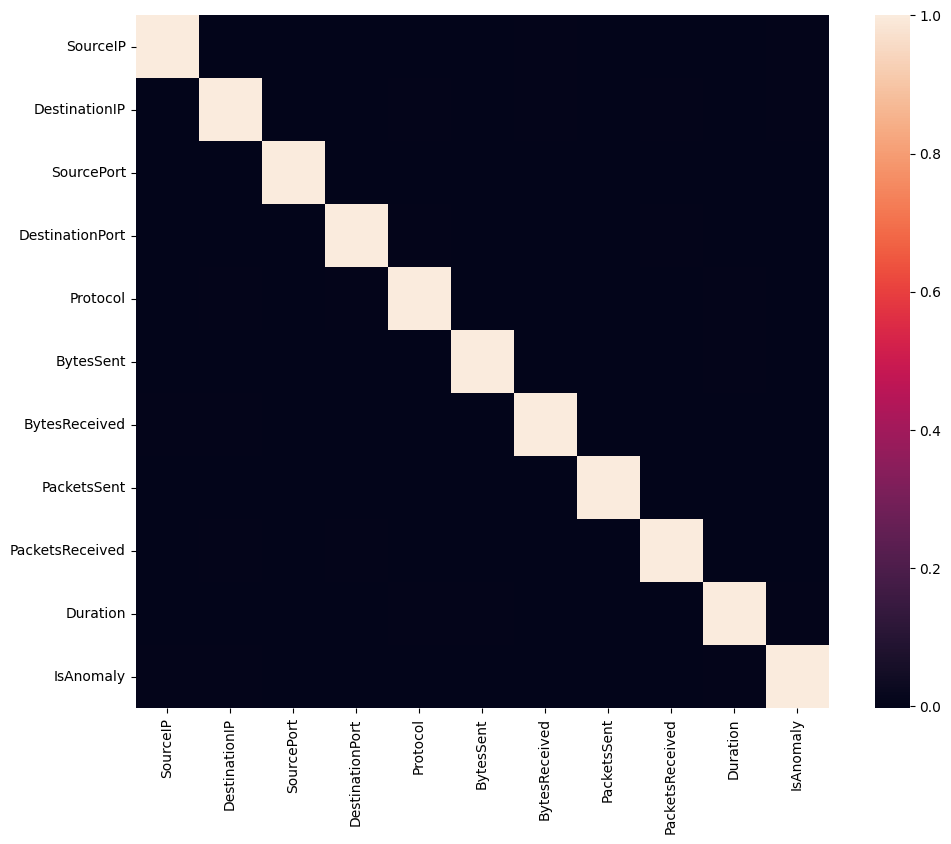

In [21]:
# I just want to check the correlation between each column, to understand what features are corelated
import seaborn as sns
correlation_matrix = df.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=1.0,square = True)
plt.show()

In [22]:
# Feature Engineering: Generate additional features (you can customize this)
df['TotalBytes'] = df['BytesSent'] + df['BytesReceived']
df['TotalPackets'] = df['PacketsSent'] + df['PacketsReceived']

In [23]:
# Oversample the 'Anomaly' class to balance the class distribution
anomaly_data = df[df['IsAnomaly'] == 1]
oversampled_data = pd.concat([df, anomaly_data], axis=0)

In [24]:
outlier_fraction = np.ceil(len(anomaly_data)/float(len(oversampled_data)))

#Let's print how many more outliers are there in the dataset compared to normal data
print(outlier_fraction)

1.0


In [25]:
# Use only the first 1000 rows
df_subset = df.head(1000)

# Perform the usual preprocessing on the subset
X = df_subset.drop(columns=['IsAnomaly'])  # Features
y = df_subset['IsAnomaly']  # Labels

In [26]:
# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [27]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [28]:
# Define a random state 
state = np.random.RandomState(42)

In [29]:
# Corrected IsolationForest initialization
classifiers = {
    "Isolation Forest": IsolationForest(n_estimators=100, contamination='auto', random_state=42),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, contamination=0.1),
    "Support Vector Machine": OneClassSVM(kernel='rbf', gamma=0.1, nu=0.05)
}

# Train and evaluate classifiers
for i, (clf_name, clf) in enumerate(classifiers.items()):
    print(f"Training {clf_name}...")

    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X_train)
    elif clf_name == "Support Vector Machine":
        clf.fit(X_train)
        y_pred = clf.predict(X_train)
    else:
        clf.fit(X_train)
        y_pred = clf.predict(X_train)

    # Reshape predictions
    y_pred = np.where(y_pred == -1, 1, 0)

    # Evaluate
    n_errors = (y_pred != y_train).sum()
    print(f"{clf_name}: Number of Errors: {n_errors}")
    print("Accuracy Score:", accuracy_score(y_train, y_pred))
    print("Classification Report:\n", classification_report(y_train, y_pred))


Training Isolation Forest...
Isolation Forest: Number of Errors: 48
Accuracy Score: 0.9314285714285714
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       693
           1       0.00      0.00      0.00         7

    accuracy                           0.93       700
   macro avg       0.49      0.47      0.48       700
weighted avg       0.98      0.93      0.95       700

Training Local Outlier Factor...
Local Outlier Factor: Number of Errors: 75
Accuracy Score: 0.8928571428571429
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94       693
           1       0.01      0.14      0.03         7

    accuracy                           0.89       700
   macro avg       0.50      0.52      0.48       700
weighted avg       0.98      0.89      0.93       700

Training Support Vector Machine...
Support Vector Machine: Number of Errors: 65
Accu

In [30]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

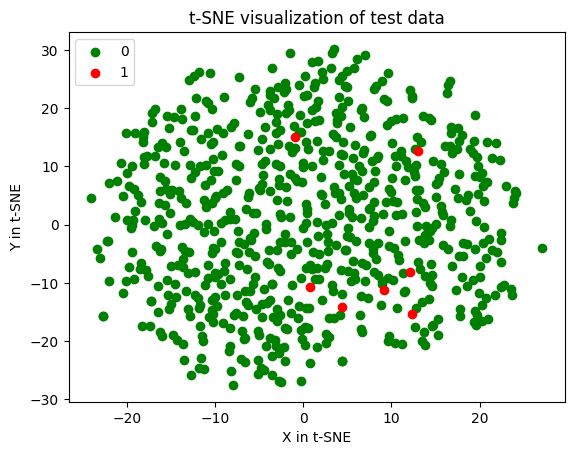

In [31]:
def tsne_plot(x1, y1, name="graph.png"):
    
    #Scale features to improve the training ability of TSNE.
    standard_scaler = StandardScaler()
    df2_std = standard_scaler.fit_transform(x1)

    tsne = TSNE(n_components=2, random_state=0)
    x_test_2d = tsne.fit_transform(df2_std)
    
    #Build the scatter plot with the two types of transactions.
    color_map = {0:'green', 1:'red'}
    plt.figure()
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = x_test_2d[y1==cl,0], 
                    y = x_test_2d[y1==cl,1], 
                    c = color_map[idx], 
                    label = cl)
    plt.xlabel('X in t-SNE')
    plt.ylabel('Y in t-SNE')
    plt.legend(loc='upper left')
    plt.title('t-SNE visualization of test data')
    plt.show()
    
tsne_plot(X_train[:8000], y_train[:8000])


In [32]:
#I think training this kind of dataset with autoencoders makes more sense so let's try that

## input layer 
input_layer = Input(shape=(X_train.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X_train.shape[1], activation='relu')(decoded)

In [33]:
#Compile the mdoel
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [34]:
from sklearn.preprocessing import MinMaxScaler

# Assuming X_train is already a NumPy array
x_scale = MinMaxScaler().fit_transform(X_train)  # No need for .values

# Split scaled data into normal and fraud classes based on labels
x_norm = x_scale[y_train == 0]  # Normal transactions
x_fraud = x_scale[y_train == 1]  # Fraudulent transactions

In [35]:
autoencoder.fit(x_norm[0:8000], x_norm[0:8000], 
                batch_size = 256, epochs = 50, 
                shuffle = True, validation_split = 0.20);

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - loss: 0.6893 - val_loss: 0.4749
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6878 - val_loss: 0.4747
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.6893 - val_loss: 0.4746
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6909 - val_loss: 0.4744
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6886 - val_loss: 0.4743
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6892 - val_loss: 0.4741
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6891 - val_loss: 0.4740
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6883 - val_loss: 0.4738
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6892 - val_loss: 0.4737
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6885 - val_loss: 0.4735
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6865 - val_loss: 0.4734
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.6878 - val_loss: 0.4732


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Assuming X_train and y_train are defined and preprocessed
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Train a logistic regression model
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

# Evaluate the model
print("Classification Report:")
print(classification_report(val_y, pred_y))

print("Accuracy Score:")
print(accuracy_score(val_y, pred_y))

Classification Report:


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       175

    accuracy                           1.00       175
   macro avg       1.00      1.00      1.00       175
weighted avg       1.00      1.00      1.00       175

Accuracy Score:
1.0


In [37]:
# Import required libraries
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Load dataset
file_path = r"synthetic_network_traffic.csv"  # Update your file path
data = pd.read_csv(file_path)

# Preprocess the data
data.fillna(data.mean(), inplace=True)
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Initialize and train Isolation Forest
model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
model.fit(data)

# Predict anomalies
data['anomaly'] = model.predict(data)
data['anomaly'] = data['anomaly'].apply(lambda x: 1 if x == -1 else 0)  # -1 indicates anomaly

# Display results
print(data['anomaly'].value_counts())


anomaly
0    900000
1    100000
Name: count, dtype: int64


In [38]:
df.IsAnomaly.unique()

array([0, 1], dtype=int64)

Implement Model

In [39]:
# Define classifiers
classifiers = {
    "Isolation Forest": IsolationForest(n_estimators=100, contamination='auto', random_state=42),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, contamination=0.1),
    "Support Vector Machine": OneClassSVM(kernel='rbf', gamma=0.1, nu=0.05)
}
# Train the models
for clf_name, clf in classifiers.items():
    print(f"Training {clf_name}...")

    if clf_name == "Local Outlier Factor":
        # LOF uses fit_predict
        y_pred = clf.fit_predict(X_train)
    else:
        # Isolation Forest and SVM use fit and predict
        clf.fit(X_train)
        y_pred = clf.predict(X_train)

    # Reshape predictions: -1 (anomaly) -> 1, 1 (normal) -> 0
    y_pred = np.where(y_pred == -1, 1, 0)

    # Convert X_train to a DataFrame if it's a NumPy array
    if isinstance(X_train, np.ndarray):
        X_train = pd.DataFrame(X_train, columns=[f"Feature_{i}" for i in range(X_train.shape[1])])

    # Store predictions for evaluation
    X_train[f"{clf_name}_pred"] = y_pred



Training Isolation Forest...
Training Local Outlier Factor...
Training Support Vector Machine...


Evaulate Model

In [40]:
from sklearn.metrics import confusion_matrix
# Evaluate each classifier
for clf_name, clf in classifiers.items():
    print(f"Evaluating {clf_name}...")

    # Ensure predictions are available
    if f"{clf_name}_pred" not in X_train.columns:
        print(f"Error: Predictions for {clf_name} not found in X_train.")
        continue

    # Ground truth vs predictions
    y_true = y_train  # Ground truth
    y_pred = X_train[f"{clf_name}_pred"].values  # Predictions

    # Evaluation metrics
    print(f"Accuracy for {clf_name}: {accuracy_score(y_true, y_pred):.2f}")
    print(f"Classification Report for {clf_name}:\n{classification_report(y_true, y_pred)}")
    print(f"Confusion Matrix for {clf_name}:\n{confusion_matrix(y_true, y_pred)}\n")



Evaluating Isolation Forest...
Accuracy for Isolation Forest: 0.93
Classification Report for Isolation Forest:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       693
           1       0.00      0.00      0.00         7

    accuracy                           0.93       700
   macro avg       0.49      0.47      0.48       700
weighted avg       0.98      0.93      0.95       700

Confusion Matrix for Isolation Forest:
[[652  41]
 [  7   0]]

Evaluating Local Outlier Factor...
Accuracy for Local Outlier Factor: 0.89
Classification Report for Local Outlier Factor:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       693
           1       0.01      0.14      0.03         7

    accuracy                           0.89       700
   macro avg       0.50      0.52      0.48       700
weighted avg       0.98      0.89      0.93       700

Confusion Matrix for Local Outlier Factor:
[[624 

In [41]:
from sklearn.model_selection import train_test_split

# Assuming 'IsAnomaly' is the label column
X = data.drop(columns=['IsAnomaly'])  # Features
y = data['IsAnomaly']  # Labels (0 = normal, 1 = anomaly)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [42]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Check and correct y_train values
print("Unique values in y_train:", np.unique(y_train))
y_train = (y_train > 0.5).astype(int)  # Example binarization based on a threshold
y_test = (y_test > 0.5).astype(int)

# Initialize XGBoost
xgb_model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=10  # Handle class imbalance
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict anomalies
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Unique values in y_train: [-0.07088812 14.10673598]
Accuracy: 0.9975766666666667
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    298540
           1       0.95      0.53      0.68      1460

    accuracy                           1.00    300000
   macro avg       0.97      0.77      0.84    300000
weighted avg       1.00      1.00      1.00    300000



In [43]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score

cat_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=5,
    scale_pos_weight=10,
    verbose=0 
)

cat_model.fit(X_train, y_train)

y_pred = cat_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9974033333333333
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    298540
           1       0.95      0.49      0.65      1460

    accuracy                           1.00    300000
   macro avg       0.97      0.75      0.82    300000
weighted avg       1.00      1.00      1.00    300000

